# Comprehensive PMF Analysis

This notebook demonstrates how to use PMF_toolkits with both single-site and multi-site data formats. It illustrates all available analysis functions and visualization capabilities.

## 1. Setup and Data Loading

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import traceback # For detailed error printing

from PMF_toolkits.core import PMF
from PMF_toolkits.readers import XlsxReader, MultisitesReader # Import readers
from PMF_toolkits.analysis import compute_similarity_metrics

# Suppress warnings (optional)
import warnings
warnings.filterwarnings('ignore')

### 1.1 Configure data directories

Let's set up paths for both single-site and multi-site data.

In [2]:
# Define data directories (adjust paths if necessary)
single_site_data_dir = "single_site"  # Path to single site PMF output files
multi_site_data_dir = "multi_site"    # Path to multi-site PMF output files

# Define site names
single_site_name = "GRE-fr"           # Single site name
multi_site_name = "11fnew"            # Multi-site name (prefix for multi-site files)

## 1.2 Quick check: Load Multi-site Data

Attempt to load the multi-site data first to verify the reader corrections.

In [ ]:
# Attempt to load multi-site data
print(f"--- Loading Multi-site Data ({multi_site_name}) ---")
pmf_multi = None # Initialize
multi_loaded = False
try:
    # Use multisites=True flag
    pmf_multi = PMF(site=multi_site_name, reader="xlsx", BDIR=multi_site_data_dir, multisites=True)
    
    # Load all data components using read_all()
    print("\nLoading all data components using read_all()...")
    pmf_multi.read.read_all()
    print("\nFinished attempting read_all().")
    
    # Verify data loading status
    multi_loaded = pmf_multi.ensure_data_loaded()
    print(f"\nData loaded check result: {multi_loaded}")
    
except Exception as main_e:
    print(f"\n❌ Major error during multi-site loading: {str(main_e)}")
    traceback.print_exc()

# Display status of key dataframes
print("\n--- Multi-site Data Status ---")
if pmf_multi is not None:
    for attr in ['dfprofiles_b', 'dfprofiles_c', 'dfcontrib_b', 'dfcontrib_c', 
                 'dfBS_profile_b', 'dfBS_profile_c', 'dfbootstrap_mapping_b', 'dfbootstrap_mapping_c',
                 'df_uncertainties_summary_b', 'df_uncertainties_summary_c', 
                 'df_disp_swap_b', 'df_disp_swap_c']:
        is_present = hasattr(pmf_multi, attr) and getattr(pmf_multi, attr) is not None
        is_empty = getattr(pmf_multi, attr).empty if is_present else True
        shape = getattr(pmf_multi, attr).shape if is_present and not is_empty else None
        status = f"Present with shape {shape}" if is_present and not is_empty else ("Present but Empty" if is_present else "Missing")
        print(f"- {attr}: {status}")
else:
    print("PMF object 'pmf_multi' could not be initialized or loading failed severely.")

--- Loading Multi-site Data (11fnew) ---
Initialized XlsxReader for site '11fnew' with multisites=True

Loading all data components using read_all()...
Total variable set to: PM10
Successfully read base profiles with shape (28, 11)
Found multiple 'Factor Contributions' sections, using first section
Successfully read base contributions with shape (3845, 12)
Successfully read base bootstrap with 101 runs
Loading base uncertainty summary from: multi_site\11fnew_BaseErrorEstimationSummary.xlsx
No DISP swap data found in base uncertainty summary
Successfully read base uncertainties summary with shape (308, 12)
Successfully read constrained profiles with shape (28, 11)
Found multiple 'Factor Contributions' sections, using first section
Successfully read constrained contributions with shape (3845, 12)
Successfully read constrained bootstrap with 101 runs
Loading constrained uncertainty summary from: multi_site\11fnew_ConstrainedErrorEstimationSummary.xlsx
Read constrained DISP swap data: {'Du

In [4]:
pmf_multi.dfcontrib_c

,Station,Dust,Biomass burning,Sea salt,Traffic,HFO,Sulfate rich,Primary biogenic,Industrial,MSA rich,Nitrate rich,Aged sea salt
Date,,,,,,,,,,,,
08/02/13,Aix-en-provence,1.8989,-0.001166,-0.057563,0.44641,2.51710,1.26680,0.41196,-0.060751,2.25670,0.043071,0.89863
08/05/13,Aix-en-provence,2.5407,0.010766,-0.019035,0.64940,2.59920,0.54565,0.60968,-0.055885,1.23390,0.118190,0.55542
08/14/13,Aix-en-provence,2.0615,0.014841,-0.016494,0.22316,0.10492,0.46978,0.85501,0.030606,1.75470,0.134410,0.82914
08/17/13,Aix-en-provence,2.4606,0.010507,-0.060974,1.34900,2.01200,1.76030,0.46757,0.376840,1.47420,-0.006194,1.06300
08/29/13,Aix-en-provence,2.5270,0.013897,-0.034075,1.03160,2.20170,0.77866,0.52152,0.258010,0.54527,0.223070,0.49733
...,...,...,...,...,...,...,...,...,...,...,...,...
06/28/21,VIF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
07/01/21,VIF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
07/04/21,VIF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Single Site Analysis

### 2.1 Load single site data

In [5]:
# Create PMF object for single site
print(f"\n--- Loading Single-site Data ({single_site_name}) ---")
pmf_single = None
single_loaded = False
try:
    # Explicitly set multisites=False
    pmf_single = PMF(site=single_site_name, reader="xlsx", BDIR=single_site_data_dir, multisites=False)
    
    # Load all data
    print("Loading all data components using read_all()...")
    pmf_single.read.read_all()
    print("\nFinished attempting read_all().")
    
    # Verify data was loaded successfully
    single_loaded = pmf_single.ensure_data_loaded()
    print(f"\nData loaded check result: {single_loaded}")
    
except Exception as e:
    print(f"\n❌ Error loading single-site data: {e}")
    traceback.print_exc()

# Display constrained contributions if loaded
if single_loaded:
    print("\nSingle-site Constrained Contributions (Head):")
    display(pmf_single.dfcontrib_c.head())
else:
    print("\nSingle-site data not fully loaded.")


--- Loading Single-site Data (GRE-fr) ---
Initialized XlsxReader for site 'GRE-fr' with multisites=False
Loading all data components using read_all()...
Total variable set to: PM10recons
Successfully read base profiles with shape (36, 11)
Found multiple 'Factor Contributions' sections, using first section
Successfully read base contributions with shape (125, 11)
Successfully read base bootstrap with 101 runs
Loading base uncertainty summary from: single_site\GRE-fr_BaseErrorEstimationSummary.xlsx
Read base DISP swap data: {'Mineral dust': 0, 'Industrial': 0, 'Aged sea salt': 0, 'Biomass burning': 0, 'Nitrate-rich': 0, 'MSA-rich': 0, 'Sea/road salt': 0, 'Sulfate-rich': 0, 'Secondary biogenic oxidation': 0, 'Primary biogenic': 0, 'Primary traffic': 0}
Successfully read base uncertainties summary with shape (396, 12)
Successfully read constrained profiles with shape (36, 11)
Found multiple 'Factor Contributions' sections, using first section
Successfully read constrained contributions wi

,Mineral dust,Industrial,Aged sea salt,Biomass burning,Nitrate-rich,MSA-rich,Sea/road salt,Sulfate-rich,Secondary biogenic oxidation,Primary biogenic,Primary traffic
Date,,,,,,,,,,,
2017-02-28,0.140340,0.13595,0.79944,0.13952,0.040197,0.090906,1.93730,0.349990,0.13695,0.095693,0.92015
2017-03-03,0.363390,0.70171,0.75625,0.47608,0.065764,0.095980,0.32590,1.192200,0.29818,0.581560,0.66591
2017-03-06,-0.097118,-0.19603,3.86750,0.32477,-0.141280,-0.178250,9.41100,0.018264,-0.11435,0.250600,-0.01362
2017-03-09,0.780870,1.49070,1.27710,0.94623,0.103090,0.149920,0.68412,2.191800,-0.11473,0.679300,0.98521
2017-03-12,0.371350,0.71706,0.67401,1.26900,0.325650,0.306510,0.27167,1.260700,1.69460,0.971420,1.76730


In [6]:
pmf_single.name = 'single'

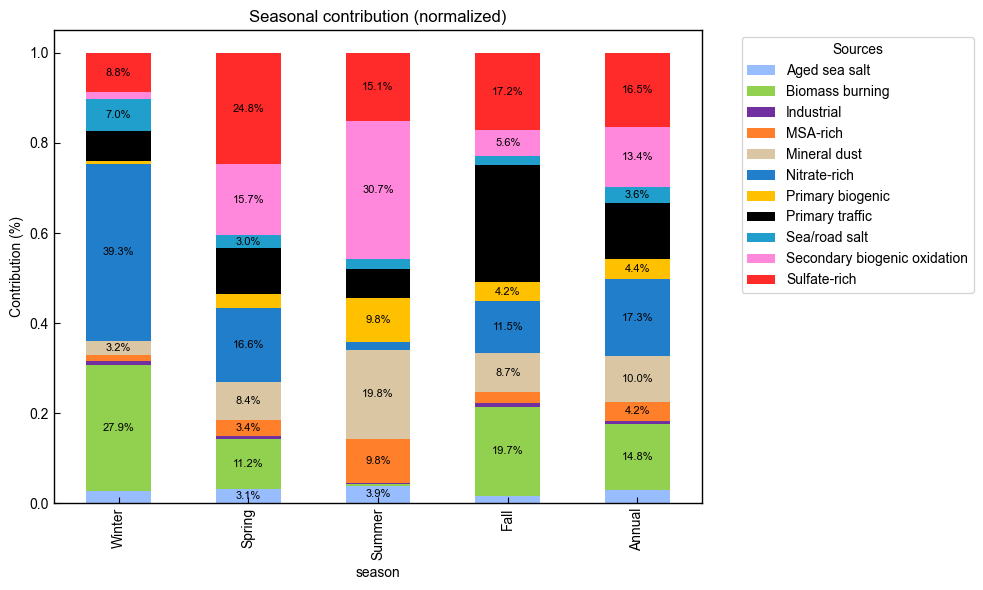

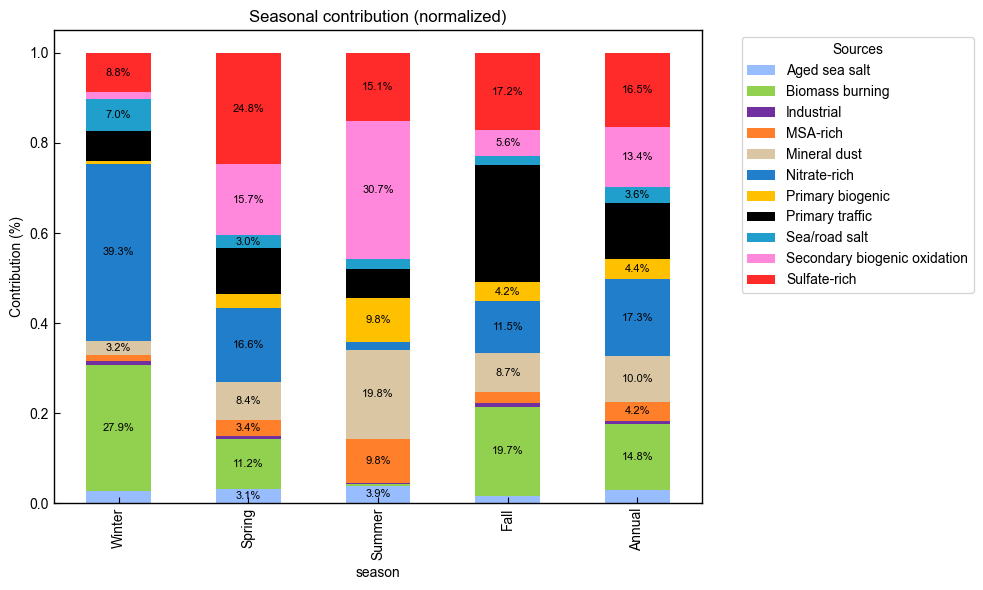

In [7]:
pmf_single.plot.plot_seasonal_contributions(stacked=True)

(<Figure size 2400x800 with 1 Axes>,
 <Axes: title={'center': 'Chemical profile of Primary traffic'}, xlabel='Species', ylabel='% of species'>)

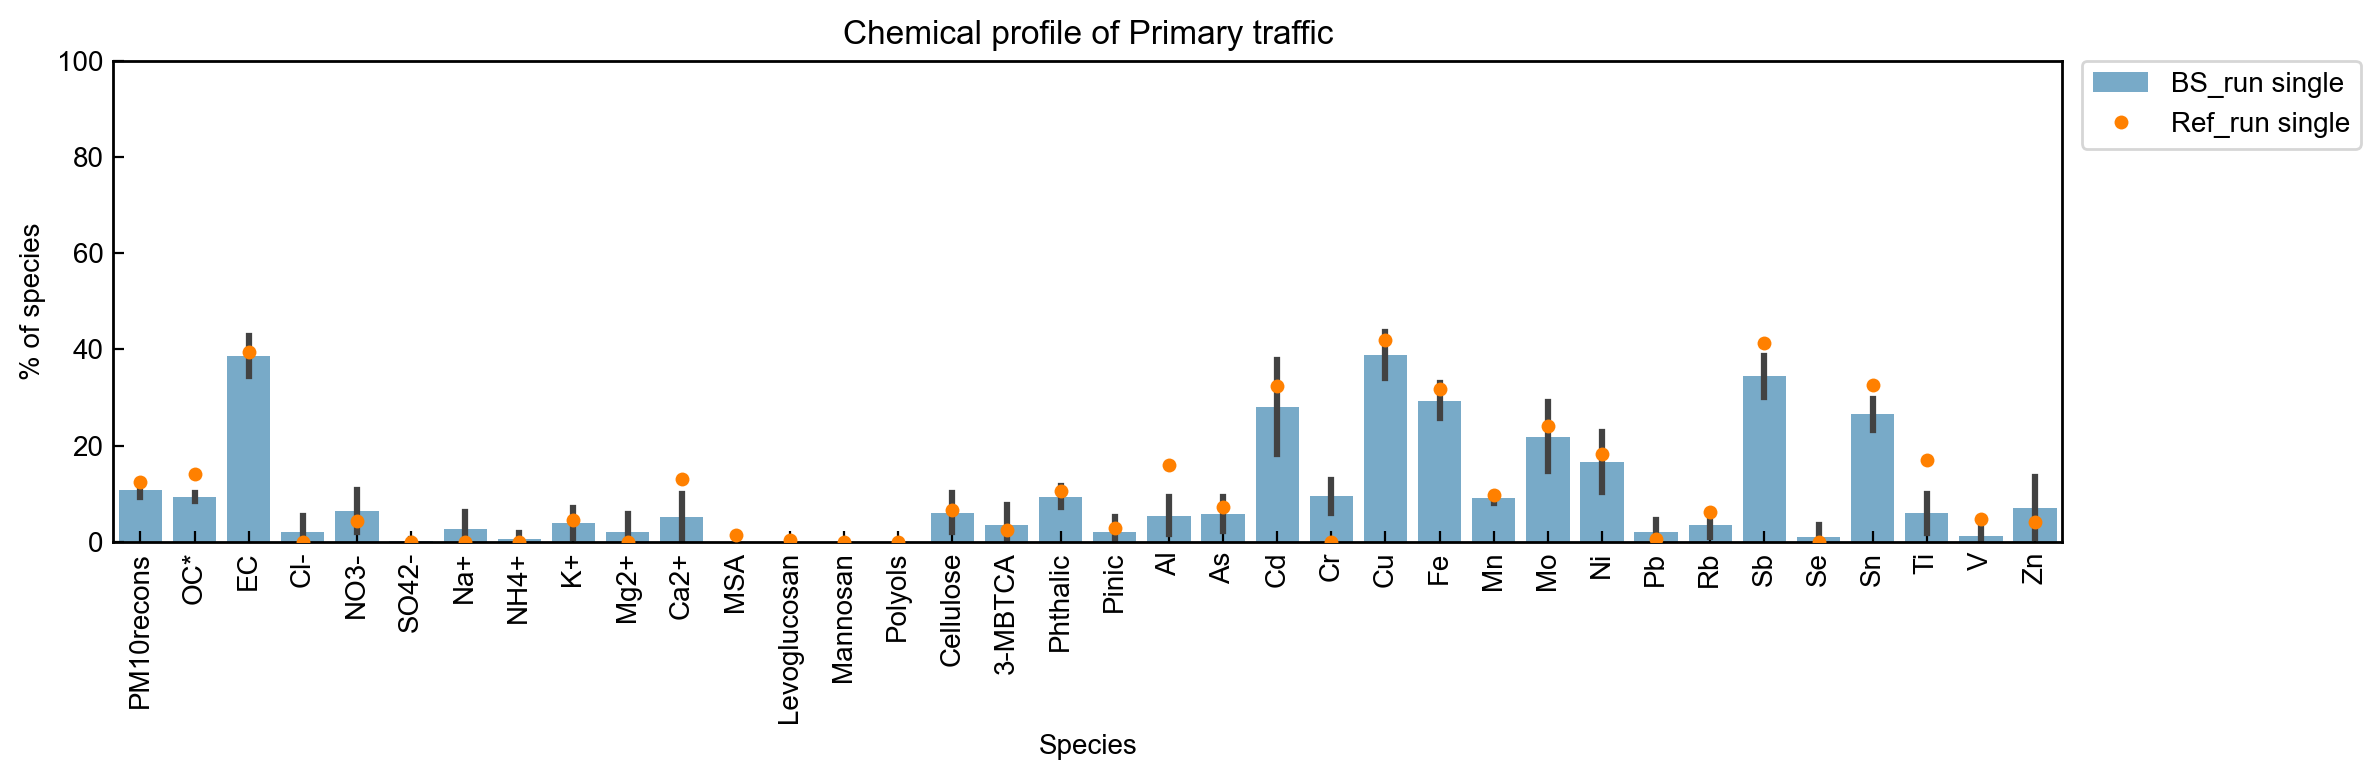

In [8]:
pmf_single.plot.plot_total_species_sum(station_list = [pmf_single],source = 'Primary traffic')

In [9]:
# Display single-site constrained profiles if loaded
if single_loaded:
    print("\nSingle-site Constrained Profiles (Head):")
    display(pmf_single.dfprofiles_c.head())


Single-site Constrained Profiles (Head):


,Mineral dust,Industrial,Aged sea salt,Biomass burning,Nitrate-rich,MSA-rich,Sea/road salt,Sulfate-rich,Secondary biogenic oxidation,Primary biogenic,Primary traffic
Specie,,,,,,,,,,,
PM10recons,1.283100,0.104730,0.392240,2.346900,2.766700,0.524550,0.546930,2.21900,1.619400,0.547750,1.763600
OC*,0.165440,0.040193,0.006565,0.968730,0.320120,0.091753,0.163700,0.76253,0.548470,0.218170,0.540090
EC,0.046536,0.036200,0.000000,0.270790,0.036715,0.000000,0.050036,0.13361,0.060131,0.020192,0.426250
Cl-,0.000000,0.000000,0.012690,0.005081,0.003037,0.000000,0.061866,0.00000,0.000000,0.000000,0.000000
NO3-,0.000000,0.018983,0.227390,0.043182,1.278200,0.000000,0.000000,0.04817,0.072419,0.026217,0.078068


### 2.2 Explore available profiles and species (Single Site)

In [10]:
if single_loaded:
    # List available profiles (factors)
    if pmf_single.profiles:
        print(f"Available Profiles (Factors): {pmf_single.profiles}")
        print(f"Number of factors: {pmf_single.nprofiles}")
    else:
        print("Profiles not loaded.")
        
    if pmf_single.totalVar:
        print(f"\nTotal Variable: {pmf_single.totalVar}")
    else:
        print("\nTotal Variable not set.")

    # Display first few species
    if pmf_single.species:
        print(f"\nFirst 10 species: {pmf_single.species[:10]}")
        print(f"Total number of species: {pmf_single.nspecies}")
    else:
        print("\nSpecies list not available.")
else:
     print("Single-site data not loaded.")

Available Profiles (Factors): ['Mineral dust', 'Industrial', 'Aged sea salt', 'Biomass burning', 'Nitrate-rich', 'MSA-rich', 'Sea/road salt', 'Sulfate-rich', 'Secondary biogenic oxidation', 'Primary biogenic', 'Primary traffic']
Number of factors: 11

Total Variable: PM10recons

First 10 species: ['PM10recons', 'OC*', 'EC', 'Cl-', 'NO3-', 'SO42-', 'Na+', 'NH4+', 'K+', 'Mg2+']
Total number of species: 36


### 2.3 Basic data inspection (Single Site)

In [11]:
if single_loaded and hasattr(pmf_single, 'dfprofiles_b') and pmf_single.dfprofiles_b is not None:
    print("Single-site Base Profiles (Head):")
    display(pmf_single.dfprofiles_b.head())

Single-site Base Profiles (Head):


,Mineral dust,Industrial,Aged sea salt,Biomass burning,Nitrate-rich,MSA-rich,Sea/road salt,Sulfate-rich,Secondary biogenic oxidation,Primary biogenic,Primary traffic
Specie,,,,,,,,,,,
PM10recons,1.023000,0.023103,0.530030,1.868300,2.551900,0.340870,0.574240,2.61760,1.573200,0.721510,2.284900
OC*,0.101470,0.000143,0.036173,0.746950,0.293180,0.055968,0.176010,0.82023,0.519340,0.265910,0.818420
EC,0.044653,0.000000,0.000000,0.216630,0.042149,0.000000,0.053689,0.13765,0.013953,0.063022,0.500170
Cl-,0.000000,0.000000,0.011476,0.004977,0.002668,0.001154,0.062416,0.00000,0.000000,0.000000,0.000000
NO3-,0.025705,0.000635,0.248540,0.050533,1.211200,0.000000,0.000000,0.12454,0.059855,0.000000,0.065756


In [12]:
if single_loaded and hasattr(pmf_single, 'dfprofiles_c') and pmf_single.dfprofiles_c is not None:
    print("Single-site Constrained Profiles (Head):")
    display(pmf_single.dfprofiles_c.head())

Single-site Constrained Profiles (Head):


,Mineral dust,Industrial,Aged sea salt,Biomass burning,Nitrate-rich,MSA-rich,Sea/road salt,Sulfate-rich,Secondary biogenic oxidation,Primary biogenic,Primary traffic
Specie,,,,,,,,,,,
PM10recons,1.283100,0.104730,0.392240,2.346900,2.766700,0.524550,0.546930,2.21900,1.619400,0.547750,1.763600
OC*,0.165440,0.040193,0.006565,0.968730,0.320120,0.091753,0.163700,0.76253,0.548470,0.218170,0.540090
EC,0.046536,0.036200,0.000000,0.270790,0.036715,0.000000,0.050036,0.13361,0.060131,0.020192,0.426250
Cl-,0.000000,0.000000,0.012690,0.005081,0.003037,0.000000,0.061866,0.00000,0.000000,0.000000,0.000000
NO3-,0.000000,0.018983,0.227390,0.043182,1.278200,0.000000,0.000000,0.04817,0.072419,0.026217,0.078068


### 2.4 Convert contributions to µg/m³ (Single Site)

In [13]:
if single_loaded:
    # Convert contributions to µg/m³ for the total variable
    try:
        contributions = pmf_single.to_cubic_meter()
        print("Total Contributions (µg/m³):")
        display(contributions.head())
    except Exception as e:
        print(f"Error calculating total contributions: {e}")

    # Get contributions for a specific species
    try:
        if pmf_single.species and "SO42-" in pmf_single.species:
            so4_contrib = pmf_single.to_cubic_meter(specie="SO42-")
            print("\nSO4 contributions (µg/m³):")
            display(so4_contrib.head())
        else:
            print("\nSO4 not found in species list or species list not available.")
    except Exception as e:
        print(f"Error calculating SO4 contributions: {e}")
else:
    print("Single-site data not loaded, skipping contribution conversion.")

Total Contributions (µg/m³):


,Mineral dust,Industrial,Aged sea salt,Biomass burning,Nitrate-rich,MSA-rich,Sea/road salt,Sulfate-rich,Secondary biogenic oxidation,Primary biogenic,Primary traffic
Date,,,,,,,,,,,
2017-02-28,0.180070,0.014238,0.313572,0.327439,0.111213,0.047685,1.059567,0.776628,0.221777,0.052416,1.622777
2017-03-03,0.466266,0.073490,0.296631,1.117312,0.181949,0.050346,0.178244,2.645492,0.482873,0.318549,1.174399
2017-03-06,-0.124612,-0.020530,1.516988,0.762203,-0.390879,-0.093501,5.147158,0.040528,-0.185178,0.137266,-0.024020
2017-03-09,1.001934,0.156121,0.500930,2.220707,0.285219,0.078641,0.374166,4.863604,-0.185794,0.372087,1.737516
2017-03-12,0.476479,0.075098,0.264374,2.978216,0.900976,0.160780,0.148584,2.797493,2.744235,0.532095,3.116810



SO4 contributions (µg/m³):


,Mineral dust,Industrial,Aged sea salt,Biomass burning,Nitrate-rich,MSA-rich,Sea/road salt,Sulfate-rich,Secondary biogenic oxidation,Primary biogenic,Primary traffic
Date,,,,,,,,,,,
2017-02-28,0.025075,0.003251,0.004947,0.004045,0.011500,0.017818,0.105445,0.130924,0.029978,0.004556,0.0
2017-03-03,0.064927,0.016781,0.004680,0.013803,0.018814,0.018812,0.017738,0.445978,0.065272,0.027687,0.0
2017-03-06,-0.017352,-0.004688,0.023931,0.009416,-0.040417,-0.034937,0.512231,0.006832,-0.025031,0.011931,-0.0
2017-03-09,0.139518,0.035650,0.007902,0.027433,0.029492,0.029384,0.037236,0.819909,-0.025114,0.032340,0.0
2017-03-12,0.066349,0.017148,0.004171,0.036791,0.093162,0.060076,0.014787,0.471603,0.370948,0.046247,0.0


In [14]:
if single_loaded:
    print("Single-site Species List:")
    print(pmf_single.species)

Single-site Species List:
['PM10recons', 'OC*', 'EC', 'Cl-', 'NO3-', 'SO42-', 'Na+', 'NH4+', 'K+', 'Mg2+', 'Ca2+', 'MSA', 'Levoglucosan', 'Mannosan', 'Polyols', 'Cellulose', '3-MBTCA', 'Phthalic', 'Pinic', 'Al', 'As', 'Cd', 'Cr', 'Cu', 'Fe', 'Mn', 'Mo', 'Ni', 'Pb', 'Rb', 'Sb', 'Se', 'Sn', 'Ti', 'V', 'Zn']


### 2.5 Calculate seasonal contributions (Single Site)

In [15]:
if single_loaded:
    # Get seasonal contributions
    try:
        seasonal_contrib = pmf_single.get_seasonal_contribution(annual=True, normalize=True)
        print("Normalized Seasonal Contributions (including Annual):")
        display(seasonal_contrib)
    except Exception as e:
        print(f"Error calculating seasonal contributions: {e}")
else:
    print("Single-site data not loaded, skipping seasonal calculation.")

Normalized Seasonal Contributions (including Annual):


,Aged sea salt,Biomass burning,Industrial,MSA-rich,Mineral dust,Nitrate-rich,Primary biogenic,Primary traffic,Sea/road salt,Secondary biogenic oxidation,Sulfate-rich
season,,,,,,,,,,,
Winter,0.027755,0.278746,0.008854,0.013027,0.032110,0.393140,0.005961,0.067803,0.070002,0.014717,0.087885
Spring,0.030967,0.112351,0.006456,0.034100,0.084392,0.166188,0.029146,0.102185,0.030006,0.156644,0.247564
Summer,0.038973,0.003453,0.003049,0.097762,0.197678,0.017058,0.097579,0.064091,0.021847,0.307339,0.151171
Fall,0.016691,0.197054,0.009782,0.023162,0.087016,0.114771,0.042361,0.260511,0.020442,0.056108,0.172101
Annual,0.028597,0.147901,0.007035,0.042013,0.100299,0.172789,0.043762,0.123648,0.035574,0.133702,0.164680


### 2.6 Calculate explained variation & temporal correlation (Single Site)

In [16]:
if single_loaded:
    # Calculate explained variation
    try:
        explained_var = pmf_single.analysis.explained_variation()
        print("Explained Variation (Head):")
        display(explained_var.head())
    except Exception as e:
        print(f"Error calculating explained variation: {e}")

    # Calculate factor temporal correlation
    try:
        temporal_corr = pmf_single.analysis.factor_temporal_correlation()
        print("\nFactor Temporal Correlation:")
        display(temporal_corr)
    except Exception as e:
        print(f"Error calculating temporal correlation: {e}")
else:
    print("Single-site data not loaded, skipping analysis.")

Explained Variation (Head):


,Mineral dust,Industrial,Aged sea salt,Biomass burning,Nitrate-rich,MSA-rich,Sea/road salt,Sulfate-rich,Secondary biogenic oxidation,Primary biogenic,Primary traffic
Specie,,,,,,,,,,,
PM10recons,0.042600,0.000510,0.003154,0.167189,0.527539,0.005343,0.021145,0.041538,0.089734,0.005255,0.095991
OC*,0.011166,0.001185,0.000014,0.449125,0.111352,0.002578,0.029866,0.077337,0.162292,0.013144,0.141941
EC,0.006591,0.007172,0.000000,0.261811,0.010927,0.000000,0.020817,0.017714,0.014553,0.000840,0.659575
Cl-,0.000000,0.000000,0.011993,0.002847,0.002309,0.000000,0.982852,0.000000,0.000000,0.000000,0.000000
NO3-,0.000000,0.000147,0.009287,0.000496,0.986572,0.000000,0.000000,0.000172,0.001572,0.000105,0.001648



Factor Temporal Correlation:


,Mineral dust,Industrial,Aged sea salt,Biomass burning,Nitrate-rich,MSA-rich,Sea/road salt,Sulfate-rich,Secondary biogenic oxidation,Primary biogenic,Primary traffic
Mineral dust,1.000000,0.074172,-0.037421,-0.153950,-0.052134,0.266442,-0.230332,-0.010744,0.494489,0.119414,0.210450
Industrial,0.074172,1.000000,-0.001597,0.477632,0.221656,-0.163727,0.180125,0.111854,-0.104231,-0.159214,0.350311
Aged sea salt,-0.037421,-0.001597,1.000000,-0.008276,-0.112716,0.095718,0.517562,-0.203672,-0.057537,-0.212677,-0.187644
Biomass burning,-0.153950,0.477632,-0.008276,1.000000,0.486862,-0.319178,0.366059,-0.049705,-0.348787,-0.420404,0.446315
Nitrate-rich,-0.052134,0.221656,-0.112716,0.486862,1.000000,-0.124316,0.090662,-0.093685,-0.237433,-0.363808,-0.009231
MSA-rich,0.266442,-0.163727,0.095718,-0.319178,-0.124316,1.000000,-0.124021,0.026203,0.316207,0.235473,-0.157449
Sea/road salt,-0.230332,0.180125,0.517562,0.366059,0.090662,-0.124021,1.000000,-0.309913,-0.261471,-0.233843,0.018378
Sulfate-rich,-0.010744,0.111854,-0.203672,-0.049705,-0.093685,0.026203,-0.309913,1.000000,-0.127052,-0.072831,-0.020369
Secondary biogenic oxidation,0.494489,-0.104231,-0.057537,-0.348787,-0.237433,0.316207,-0.261471,-0.127052,1.000000,0.320932,-0.078687
Primary biogenic,0.119414,-0.159214,-0.212677,-0.420404,-0.363808,0.235473,-0.233843,-0.072831,0.320932,1.000000,0.059004


### 2.7 Advanced analysis (Single Site)

In [17]:
if single_loaded:
    # Analyze factor profiles using correlation
    try:
        factor_analysis = pmf_single.analysis.analyze_factor_profiles(method="correlation")
        # Display correlation matrix
        print("Factor Profile Correlation Matrix:")
        display(factor_analysis['correlation_matrix'])
    except Exception as e:
        print(f"Error analyzing factor profiles: {e}")

    # Detect potentially mixed factors
    try:
        mixed_factors = pmf_single.analysis.detect_mixed_factors(threshold=0.5)
        print(f"\nPotentially mixed factors (threshold=0.5): {mixed_factors}")
    except Exception as e:
        print(f"Error detecting mixed factors: {e}")
else:
    print("Single-site data not loaded, skipping advanced analysis.")

Factor Profile Correlation Matrix:


,Mineral dust,Industrial,Aged sea salt,Biomass burning,Nitrate-rich,MSA-rich,Sea/road salt,Sulfate-rich,Secondary biogenic oxidation,Primary biogenic,Primary traffic
Mineral dust,1.000000,0.881735,0.812931,0.935299,0.880522,0.955717,0.967786,0.965192,0.965099,0.952040,0.947534
Industrial,0.881735,1.000000,0.748374,0.897366,0.824717,0.855875,0.899373,0.907455,0.901714,0.897851,0.929763
Aged sea salt,0.812931,0.748374,1.000000,0.769819,0.949156,0.767782,0.793201,0.787203,0.802308,0.793086,0.794419
Biomass burning,0.935299,0.897366,0.769819,1.000000,0.849038,0.896562,0.977474,0.977823,0.979133,0.984707,0.980326
Nitrate-rich,0.880522,0.824717,0.949156,0.849038,1.000000,0.870256,0.873876,0.883172,0.896354,0.872652,0.865802
MSA-rich,0.955717,0.855875,0.767782,0.896562,0.870256,1.000000,0.944822,0.963341,0.958145,0.927893,0.892665
Sea/road salt,0.967786,0.899373,0.793201,0.977474,0.873876,0.944822,1.000000,0.989877,0.989653,0.982680,0.976335
Sulfate-rich,0.965192,0.907455,0.787203,0.977823,0.883172,0.963341,0.989877,1.000000,0.998872,0.989869,0.968384
Secondary biogenic oxidation,0.965099,0.901714,0.802308,0.979133,0.896354,0.958145,0.989653,0.998872,1.000000,0.991302,0.968400
Primary biogenic,0.952040,0.897851,0.793086,0.984707,0.872652,0.927893,0.982680,0.989869,0.991302,1.000000,0.969211



Potentially mixed factors (threshold=0.5): [('Aged sea salt', 'Sea/road salt')]


## 3. Visualizations for Single Site Data

### 3.1 Plot factor profiles (Single Site)

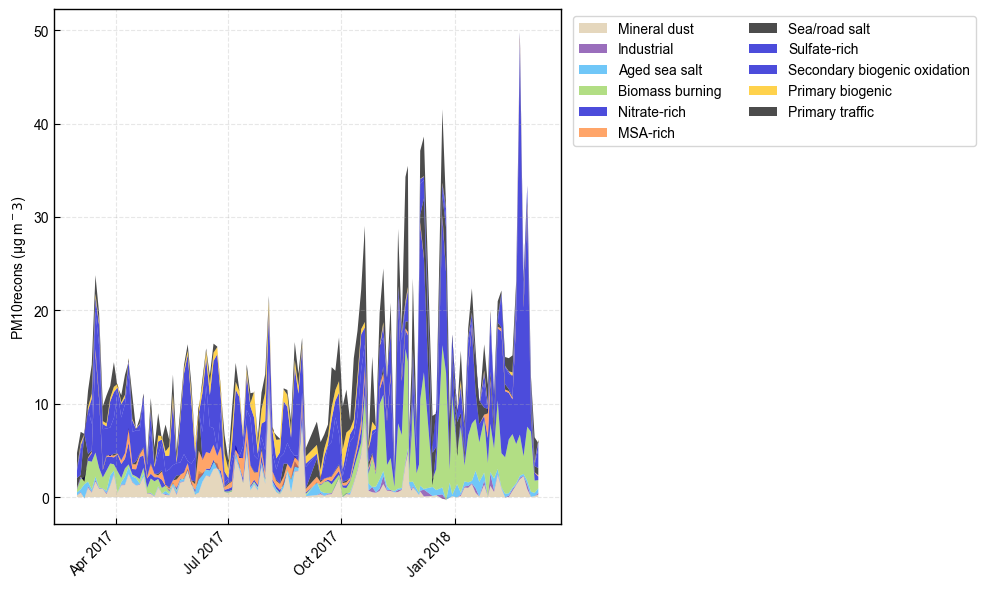

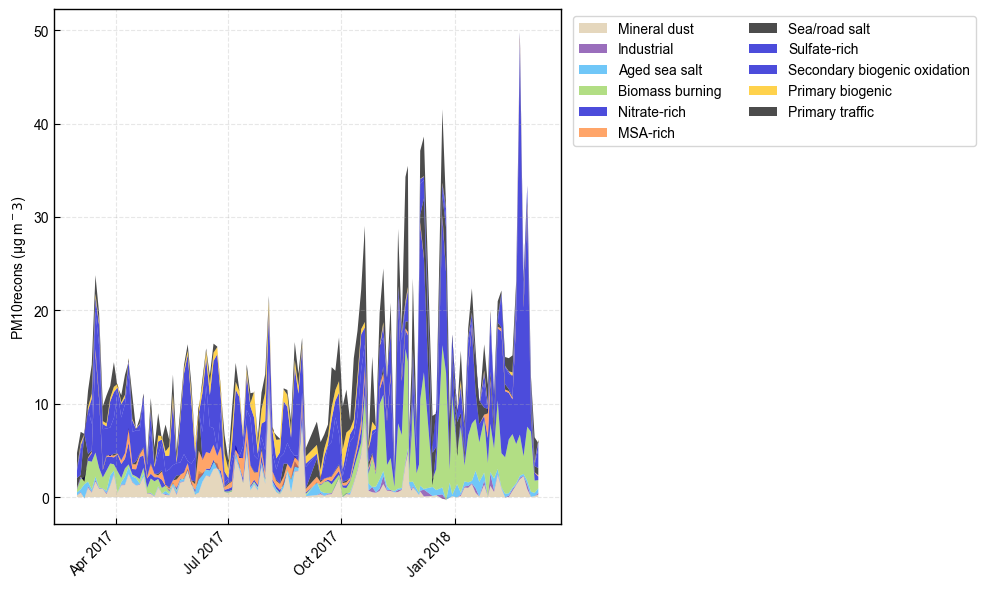

In [18]:
pmf_single.plot.plot_time_series(stacked = True)

Plotting single-site factor profiles...


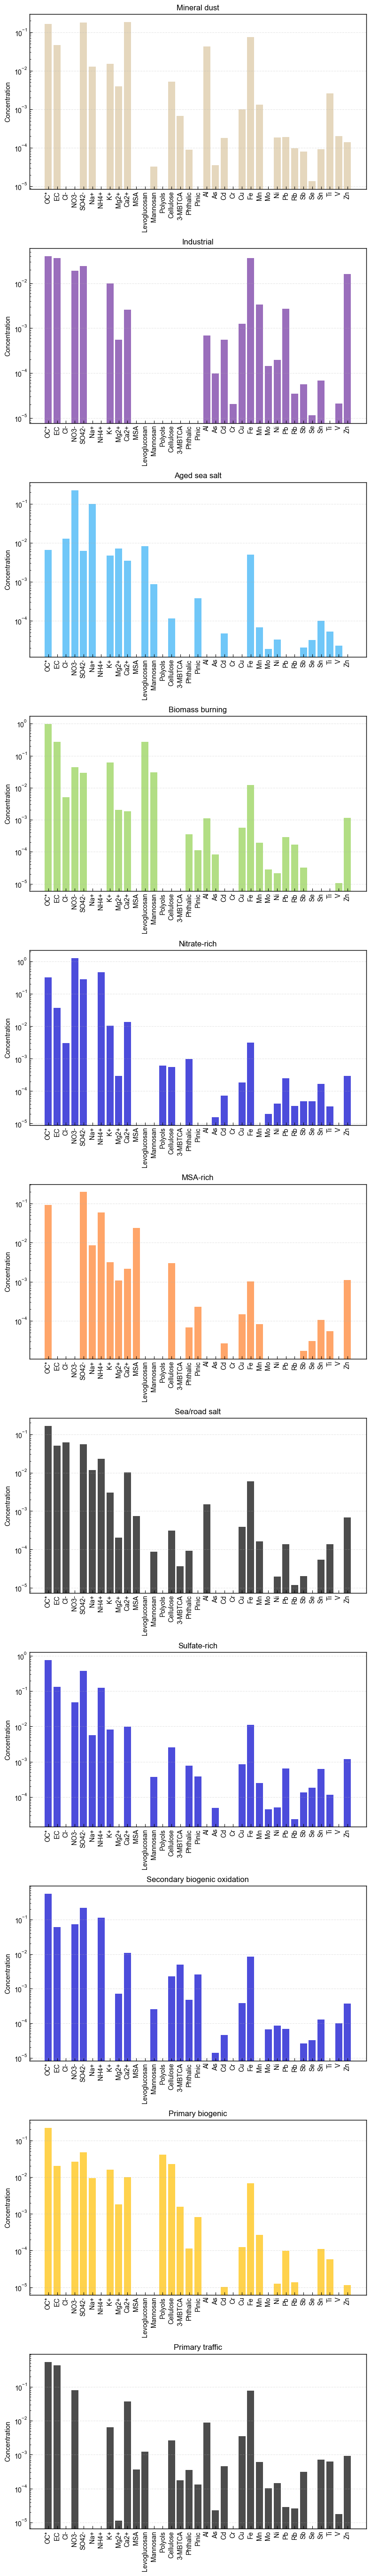

In [19]:
if single_loaded:
    # Plot factor profiles
    try:
        print("Plotting single-site factor profiles...")
        fig = pmf_single.plot.plot_factor_profiles(normalize=True, log_scale=True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting factor profiles: {e}")
else:
    print("Single-site data not loaded, skipping plot.")

### 3.2 Plot time series contribution (Single Site)

Plotting single-site time series (rolling mean)...


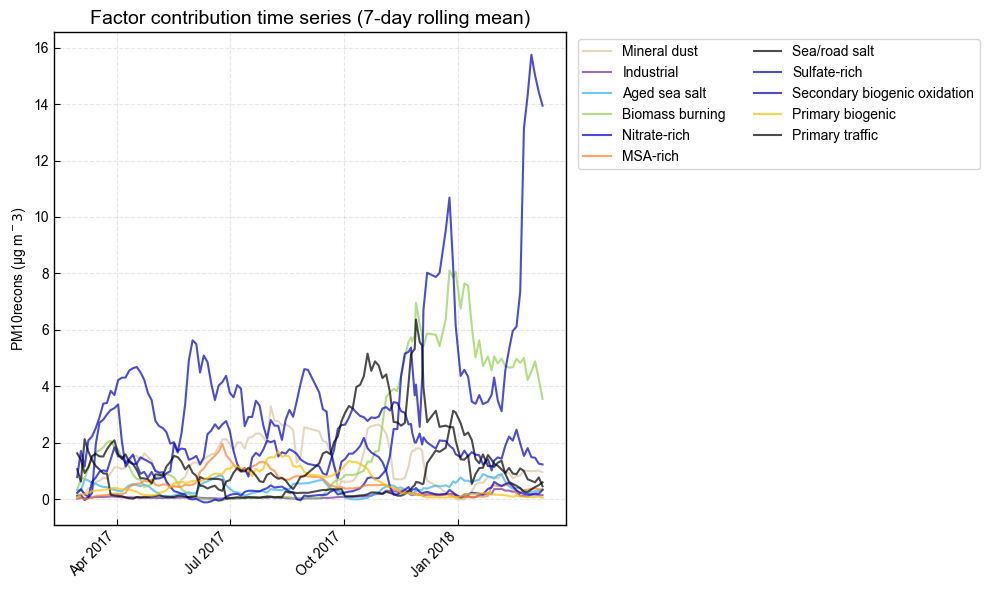

In [20]:
if single_loaded:
    # Plot with rolling mean
    try:
        print("Plotting single-site time series (rolling mean)...")
        fig = pmf_single.plot.plot_time_series(rolling_mean=7)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting time series (rolling): {e}")
else:
    print("Single-site data not loaded, skipping plot.")

Plotting single-site time series (rolling mean)...


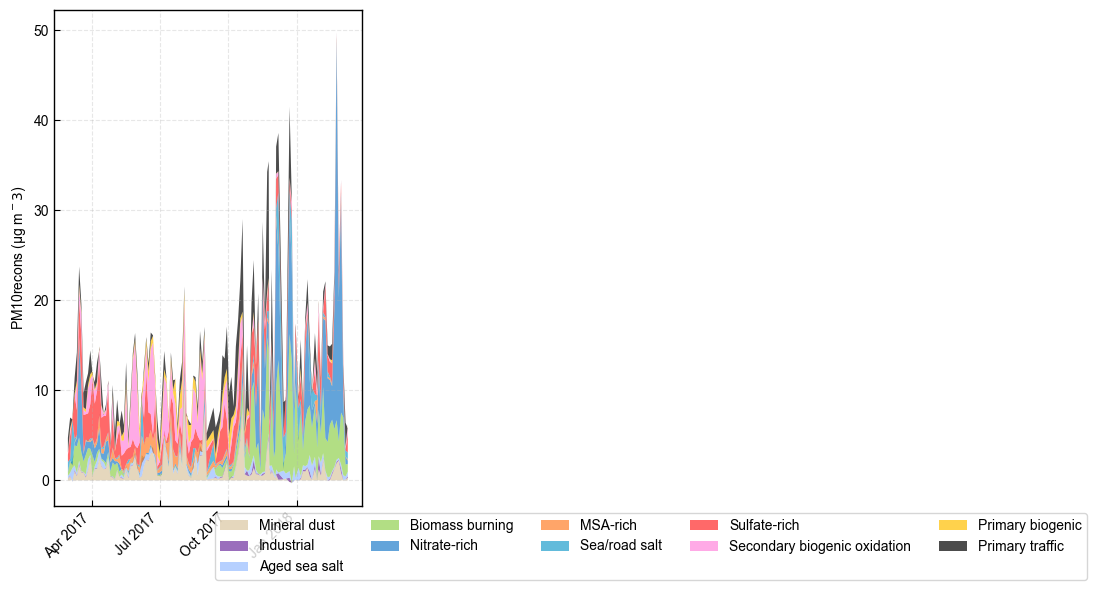

In [21]:
if single_loaded:
    # Plot with rolling mean
    try:
        print("Plotting single-site time series (rolling mean)...")
        fig = pmf_single.plot.plot_contributions_timeseries(stacked=True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting time series (rolling): {e}")
else:
    print("Single-site data not loaded, skipping plot.")

### 3.3 Plot seasonal contribution pattern (Single Site)

In [22]:
if single_loaded:
    # Plot seasonal contributions
    try:
        print("Plotting single-site seasonal contributions...")
        # The function returns the dataframe used for plotting
        df_seasonal_plot = pmf_single.plot.plot_seasonal_contribution(normalize=False, annual=True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting seasonal contribution: {e}")
else:
    print("Single-site data not loaded, skipping plot.")

Plotting single-site seasonal contributions...
Error plotting seasonal contribution: 'PMFVisualization' object has no attribute 'plot_seasonal_contribution'


### 3.4 Plot stacked profiles (Single Site)

Plotting single-site stacked profiles...


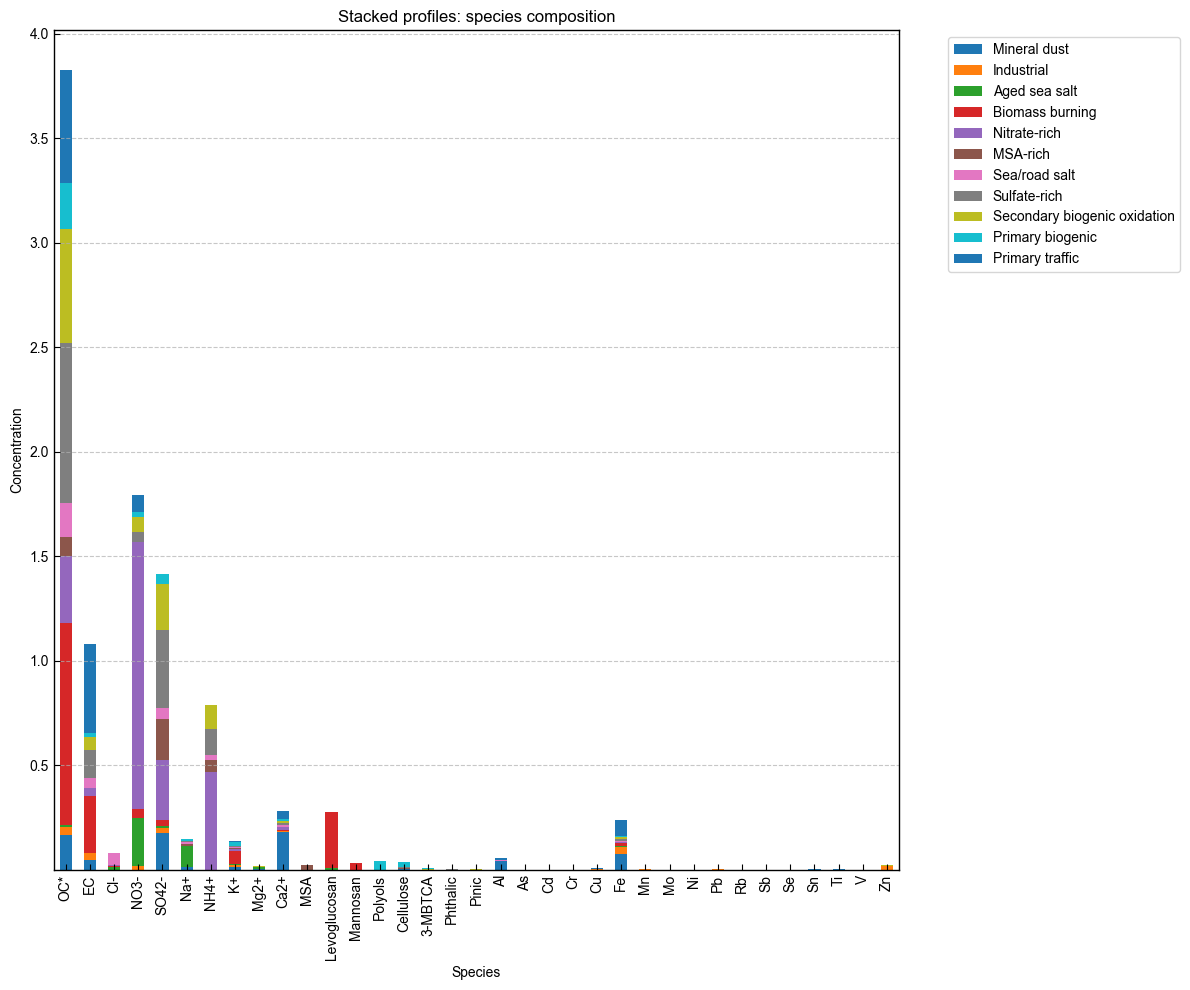

In [23]:
if single_loaded:
    # Plot stacked profiles
    try:
        print("Plotting single-site stacked profiles...")
        fig = pmf_single.plot.plot_stacked_profiles(constrained=True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting stacked profiles: {e}")
else:
    print("Single-site data not loaded, skipping plot.")

### 3.5 Plot samples contributions (Single Site)

Plotting single-site sample contributions...
Limiting display to 30 samples


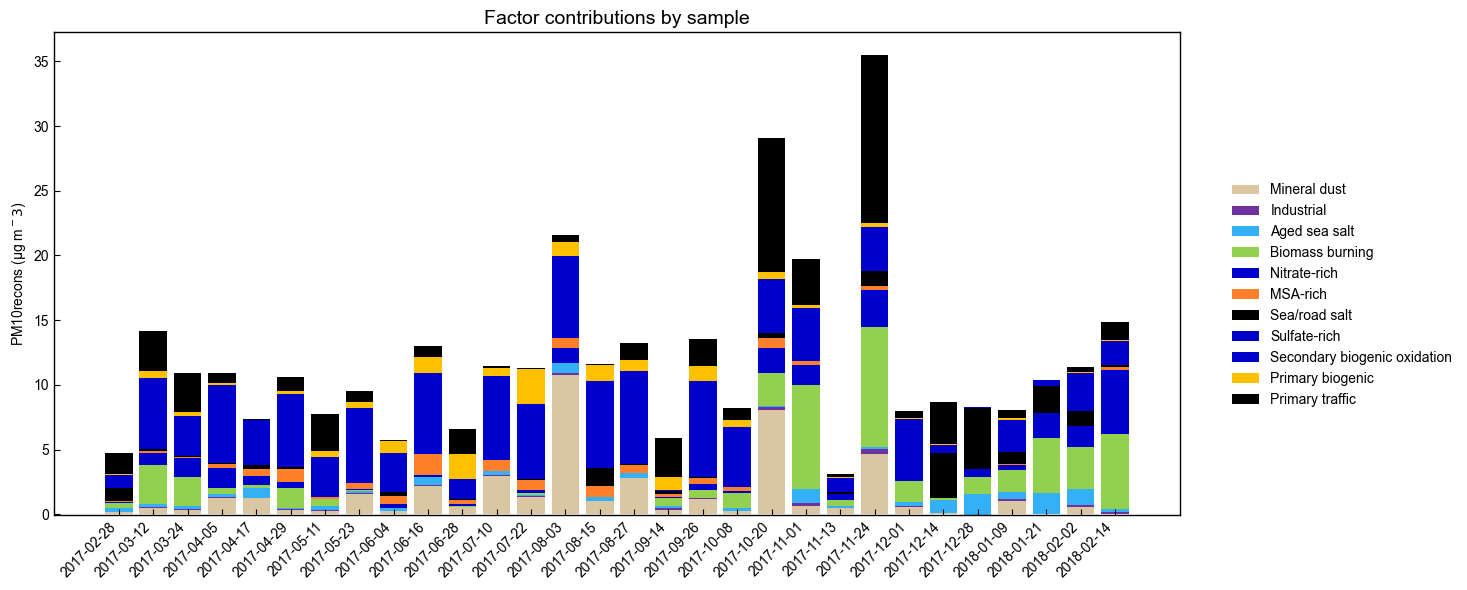

In [24]:
if single_loaded:
    # Plot contribution per sample over time
    try:
        print("Plotting single-site sample contributions...")
        fig = pmf_single.plot.plot_samples_sources_contribution(constrained=True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting sample contributions: {e}")
else:
    print("Single-site data not loaded, skipping plot.")

### 3.6 Plot per microgram profile (Single Site)

Plotting single-site per microgram profile...


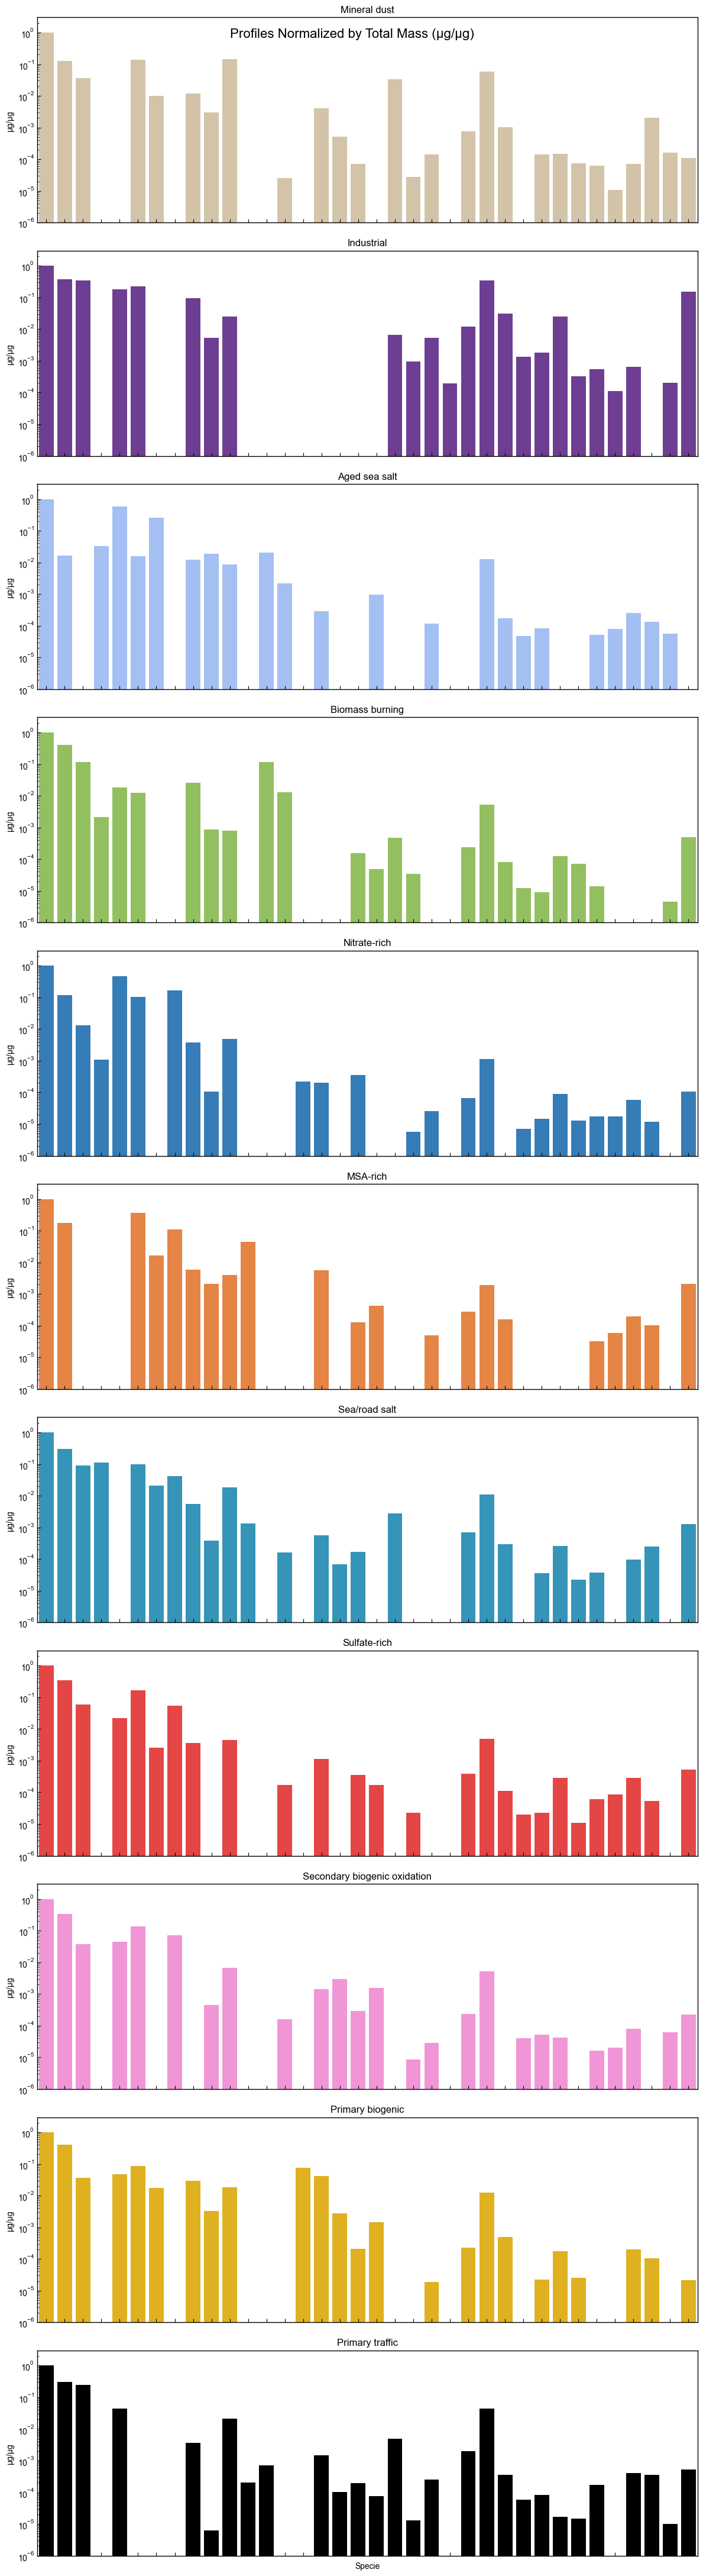

In [25]:
if single_loaded:
    # Plot per microgram profile
    try:
        print("Plotting single-site per microgram profile...")
        fig = pmf_single.plot.plot_per_microgram(constrained=True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting per microgram profile: {e}")
else:
    print("Single-site data not loaded, skipping plot.")

### 3.7 Plot individual factor profile with uncertainties (Single Site)

In [26]:
if single_loaded:
    # Select a factor to plot in detail
    if pmf_single.profiles:
        factor_to_plot = pmf_single.profiles[0]
        print(f"Plotting details for factor: {factor_to_plot}")
        # Plot profile uncertainty
        try:
            fig = pmf_single.plot.plot_profile_uncertainty(profile=factor_to_plot, constrained=True)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error plotting profile uncertainty: {e}")
    else:
        print("No profiles loaded to plot.")
else:
    print("Single-site data not loaded, skipping plot.")

Plotting details for factor: Mineral dust
Error plotting profile uncertainty: 'PMFVisualization' object has no attribute 'plot_profile_uncertainty'


### 3.8 Plot source profile details (Single Site)

Plotting source profile details for: Mineral dust


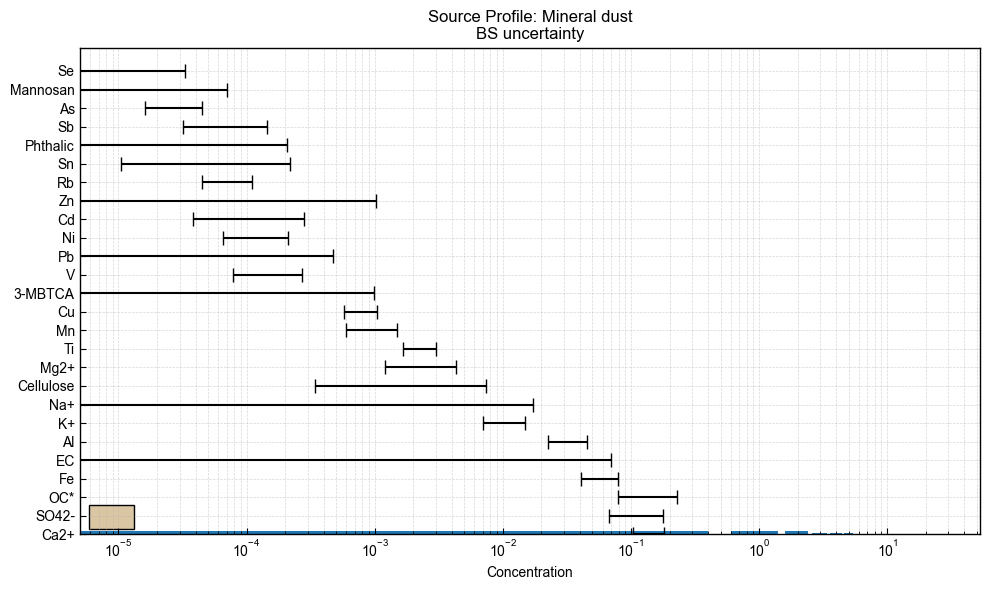

In [27]:
if single_loaded:
    # Plot detailed source profile
    if pmf_single.profiles:
        factor_to_plot = pmf_single.profiles[0]
        try:
            print(f"Plotting source profile details for: {factor_to_plot}")
            # This function might generate multiple plots or print output
            pmf_single.plot.plot_source_profile(profile=factor_to_plot, constrained=True)
            # No plt.show() needed if the function handles it
        except Exception as e:
            print(f"Error plotting source profile details: {e}")
    else:
        print("No profiles loaded to plot.")
else:
    print("Single-site data not loaded, skipping plot.")

### 3.9 Plot comprehensive profile information (Single Site)

## 4. Multi-Site Analysis & Visualizations

### 4.1 Explore multi-site data (if loaded)

In [29]:
# Check if multi-site data was loaded successfully
if multi_loaded:
    print(f"--- Exploring Multi-site Data ({multi_site_name}) ---")
    if pmf_multi.profiles:
        print(f"Available Profiles (Factors): {pmf_multi.profiles}")
        print(f"Number of factors: {pmf_multi.nprofiles}")
    if pmf_multi.totalVar:
        print(f"\nTotal Variable: {pmf_multi.totalVar}")
    
    # Display first few species
    if hasattr(pmf_multi, 'species') and pmf_multi.species is not None:
        print(f"\nFirst 10 species: {pmf_multi.species[:10]}")
        print(f"Total number of species: {pmf_multi.nspecies}")
        
    # Show profile data
    if hasattr(pmf_multi, 'dfprofiles_c') and pmf_multi.dfprofiles_c is not None and not pmf_multi.dfprofiles_c.empty:
        print("\nFactor Profiles (constrained) - Head:")
        display(pmf_multi.dfprofiles_c.head())
    else:
         print("\nMulti-site constrained profiles not loaded or empty.")
    
    # Show contributions data if loaded
    if hasattr(pmf_multi, 'dfcontrib_c') and pmf_multi.dfcontrib_c is not None and not pmf_multi.dfcontrib_c.empty:
        print("\nFactor Contributions (constrained) - Head:")
        display(pmf_multi.dfcontrib_c.head())
        # Show unique stations
        if 'Station' in pmf_multi.dfcontrib_c.columns:
             print(f"\nUnique stations found: {pmf_multi.dfcontrib_c['Station'].unique().tolist()}")
    else:
        print("\nMulti-site constrained contributions not loaded or empty.")
else:
    print("Multi-site data was not loaded successfully. Skipping multi-site exploration.")

--- Exploring Multi-site Data (11fnew) ---
Available Profiles (Factors): ['Dust', 'Biomass burning', 'Sea salt', 'Traffic', 'HFO', 'Sulfate rich', 'Primary biogenic', 'Industrial', 'MSA rich', 'Nitrate rich', 'Aged sea salt']
Number of factors: 11

Total Variable: PM10

First 10 species: ['PM10', 'OC', 'EC', 'Cl-', 'NO3-', 'SO42-', 'Na+', 'NH4+', 'K+', 'Mg2+']
Total number of species: 28

Factor Profiles (constrained) - Head:


,Dust,Biomass burning,Sea salt,Traffic,HFO,Sulfate rich,Primary biogenic,Industrial,MSA rich,Nitrate rich,Aged sea salt
Specie,,,,,,,,,,,
PM10,3.187800,3.015500,0.79266,0.795080,0.30913,3.605400,1.229500,0.386320,0.823190,2.055400,1.400700
OC,0.812020,1.437600,0.00000,0.158500,0.00000,1.042200,0.343330,0.067060,0.083236,0.034988,0.192930
EC,0.406180,0.344590,0.00000,0.066812,0.00000,0.081801,0.040659,0.000000,0.000000,0.000000,0.057128
Cl-,0.000000,0.017839,0.35644,0.006377,0.00000,0.010009,0.000000,0.002958,0.006074,0.007954,0.000000
NO3-,0.013713,0.080938,0.00000,0.056357,0.00000,0.000000,0.000000,0.019666,0.000000,1.621600,0.445380



Factor Contributions (constrained) - Head:


,Station,Dust,Biomass burning,Sea salt,Traffic,HFO,Sulfate rich,Primary biogenic,Industrial,MSA rich,Nitrate rich,Aged sea salt
Date,,,,,,,,,,,,
08/02/13,Aix-en-provence,1.8989,-0.001166,-0.057563,0.44641,2.51710,1.26680,0.41196,-0.060751,2.25670,0.043071,0.89863
08/05/13,Aix-en-provence,2.5407,0.010766,-0.019035,0.64940,2.59920,0.54565,0.60968,-0.055885,1.23390,0.118190,0.55542
08/14/13,Aix-en-provence,2.0615,0.014841,-0.016494,0.22316,0.10492,0.46978,0.85501,0.030606,1.75470,0.134410,0.82914
08/17/13,Aix-en-provence,2.4606,0.010507,-0.060974,1.34900,2.01200,1.76030,0.46757,0.376840,1.47420,-0.006194,1.06300
08/29/13,Aix-en-provence,2.5270,0.013897,-0.034075,1.03160,2.20170,0.77866,0.52152,0.258010,0.54527,0.223070,0.49733



Unique stations found: ['Aix-en-provence', 'Calais', 'Chamonix', 'GRE-cb', 'GRE-fr', 'Gardanne', 'Le Havre', 'Lens', 'Lyon-CARA-2012', 'MRS-5av', 'Malet', 'Marnaz', 'Meyreuil', 'Nice', 'Nogent', 'Passy', 'Peyrusse', 'Poitiers', 'Roubaix', 'Rouen', 'SIRTA', 'Talence', 'VIF']


### 4.2 Multi-site visualizations (if data loaded)

--- Multi-site Visualizations ---

Plotting Multi-site Factor Profiles:


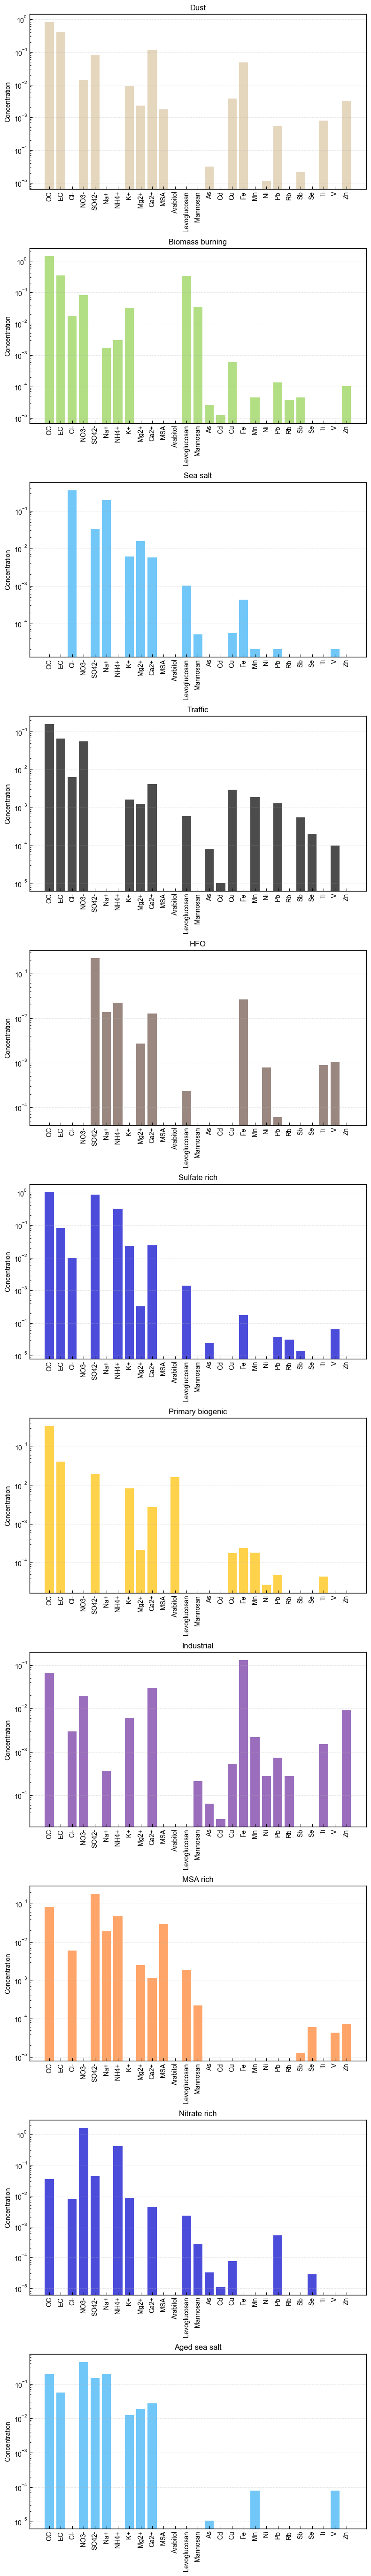

In [30]:
# Only run this if multi-site data was successfully loaded
if multi_loaded:
    print("--- Multi-site Visualizations ---")
    try:
        # Plot factor profiles (often the same across sites in multi-site PMF)
        if hasattr(pmf_multi, 'dfprofiles_c') and pmf_multi.dfprofiles_c is not None and not pmf_multi.dfprofiles_c.empty:
            print("\nPlotting Multi-site Factor Profiles:")
            fig = pmf_multi.plot.plot_factor_profiles(normalize=True)
            plt.tight_layout()
            plt.show()
        else:
            print("\nSkipping profile plot as constrained profiles are not available.")
    except Exception as e:
        print(f"Error plotting multi-site data: {str(e)}")
        traceback.print_exc()
else:
    print("Skipping multi-site visualizations as data was not loaded successfully.")

## 5. Comparison between Sites (if both loaded)

--- Comparing Single-site vs Multi-site Data ---

Common species between sites: 25

Comparing profile 'Mineral dust' (single) vs 'Dust' (multi) - CAUTION: Factors may not match!

Similarity metrics between 'Mineral dust' and 'Dust':
- SID: 0.7163
- PD: 0.8199
- COD: 0.7636
- n_species: 25.0000


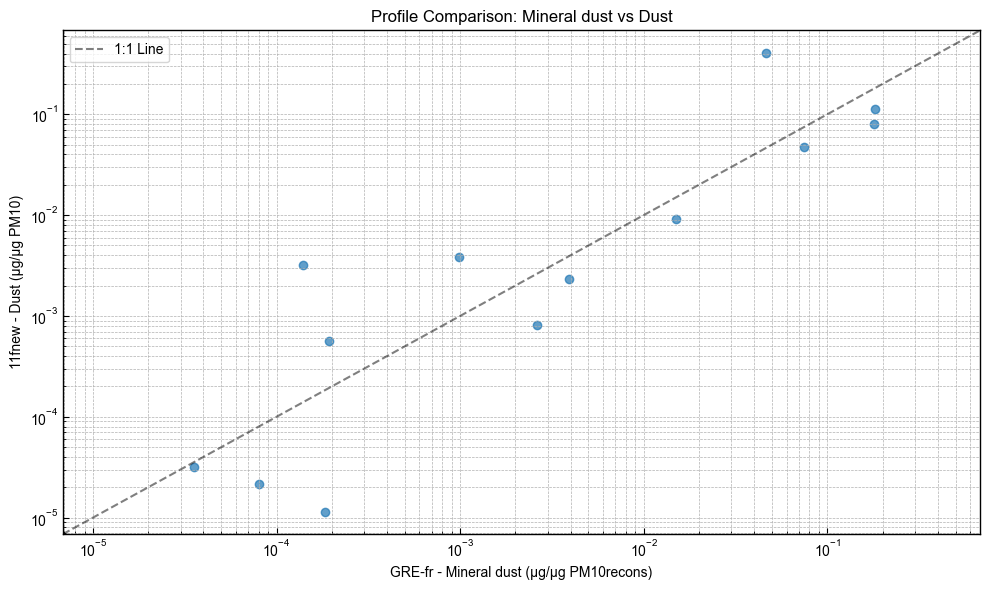

In [33]:
# Only run this if both datasets were successfully loaded
if single_loaded and multi_loaded:
    print("--- Comparing Single-site vs Multi-site Data ---")
    try:
        # Find common species between the two sites
        common_species = set(pmf_single.species).intersection(set(pmf_multi.species))
        print(f"\nCommon species between sites: {len(common_species)}")
        
        if len(common_species) > 0 and pmf_single.profiles and pmf_multi.profiles:
            # Compare profiles using common species
            species_list = list(common_species)
            
            # Select first factor from each (ensure factors exist)
            # WARNING: Factors might not correspond directly! This is just an example.
            single_factor = pmf_single.profiles[0]
            multi_factor = pmf_multi.profiles[0]
            print(f"\nComparing profile '{single_factor}' (single) vs '{multi_factor}' (multi) - CAUTION: Factors may not match!")
            
            # Single site profile for the factor
            single_profile = pmf_single.dfprofiles_c[single_factor].loc[species_list]
            
            # Multi site profile for the factor
            multi_profile = pmf_multi.dfprofiles_c[multi_factor].loc[species_list]
            
            # Calculate similarity metrics
            similarity_metrics = compute_similarity_metrics(single_profile, multi_profile)
            print(f"\nSimilarity metrics between '{single_factor}' and '{multi_factor}':")
            for metric, value in similarity_metrics.items():
                print(f"- {metric}: {value:.4f}")
            
            # Plot comparison (scatter plot)
            plt.figure(figsize=(10, 6))
            plt.scatter(single_profile, multi_profile, alpha=0.7)
            plt.xscale('log')
            plt.yscale('log')
            plt.xlabel(f"{single_site_name} - {single_factor} (µg/µg {pmf_single.totalVar or ''})")
            plt.ylabel(f"{multi_site_name} - {multi_factor} (µg/µg {pmf_multi.totalVar or ''})")
            plt.title(f"Profile Comparison: {single_factor} vs {multi_factor}")
            
            # Add 1:1 line for reference
            valid_vals = single_profile.fillna(0) + multi_profile.fillna(0)
            min_val = (valid_vals[valid_vals > 0]).min() * 0.5 # Avoid log(0)
            max_val = valid_vals.max() * 1.5
            if pd.notna(min_val) and pd.notna(max_val) and min_val > 0:
                plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='1:1 Line')
                plt.xlim(min_val, max_val)
                plt.ylim(min_val, max_val)
            
            # Add labels for a few key species (optional, can get crowded)
            # for sp in species_list:
            #     sp_single_val = single_profile.get(sp)
            #     sp_multi_val = multi_profile.get(sp)
            #     if pd.notna(sp_single_val) and pd.notna(sp_multi_val) and (sp_single_val > 0.01 or sp_multi_val > 0.01): # Threshold for labeling
            #         plt.annotate(sp, (sp_single_val, sp_multi_val), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)
            
            plt.legend()
            plt.grid(True, which='both', linestyle='--', linewidth=0.5)
            plt.tight_layout()
            plt.show()
        else:
            print("Cannot compare profiles: No common species or profiles are missing.")
            
    except Exception as e:
        print(f"Error comparing sites: {str(e)}")
        traceback.print_exc()
else:
    print("Skipping site comparison as one or both datasets were not loaded successfully.")

In [34]:
pmf_single.get_total_species_sum().index
pmf_multi.get_total_species_sum().index

Index(['PM10', 'OC', 'EC', 'Cl-', 'NO3-', 'SO42-', 'Na+', 'NH4+', 'K+', 'Mg2+',
       'Ca2+', 'MSA', 'Arabitol', 'Levoglucosan', 'Mannosan', 'As', 'Cd', 'Cu',
       'Fe', 'Mn', 'Ni', 'Pb', 'Rb', 'Sb', 'Se', 'Ti', 'V', 'Zn'],
      dtype='object', name='Specie')

In [35]:
pmf_single.name = "single"
pmf_multi.name = "multi"

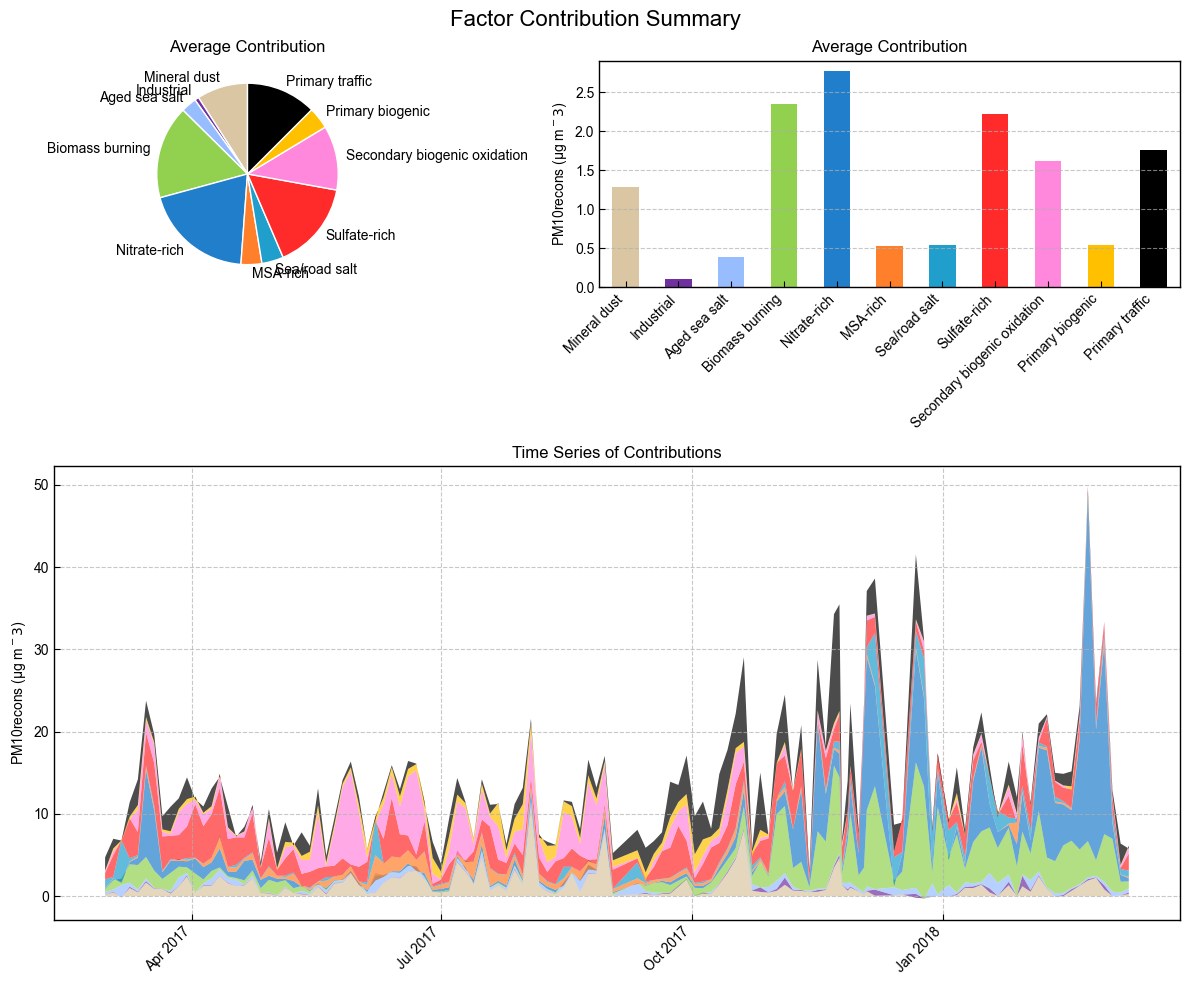

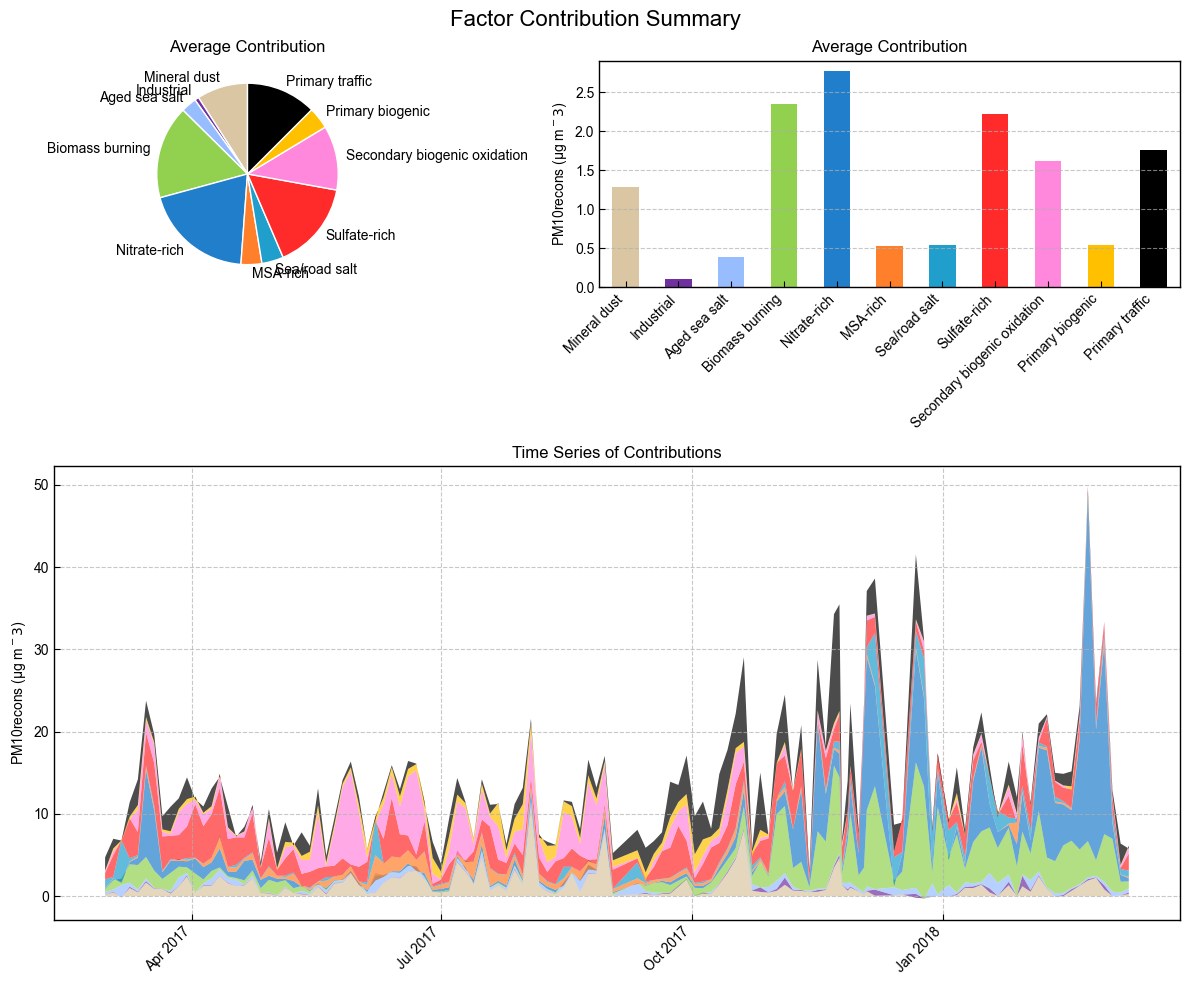

In [36]:
pmf_single.plot.plot_contribution_summary()